In [193]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd
from scipy import optimize

In [194]:
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.5
v = 0
delta_u = 1.
mu_M = 0.00001
mu_Q = 0.00001
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [229]:
num_neurons = 30
num_timebins = 10

weights = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
# weights = np.array(
#     [[0, 0.1],
#     [0, 0]]
# )
# weights = np.ones((num_neurons, num_neurons))
np.fill_diagonal(weights, 0)
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])



In [230]:

for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [111]:
gaussian_intervals = np.random.normal(size = 100, loc=30, scale=10).astype(int)

In [112]:
## staircase pattern
neuron_block_size = np.floor(num_neurons / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1
    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 10.0
    nonblock_idx = np.delete(np.arange(num_neurons), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    rho[nonblock_idx, tt] = 0.05


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
    
    
    
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

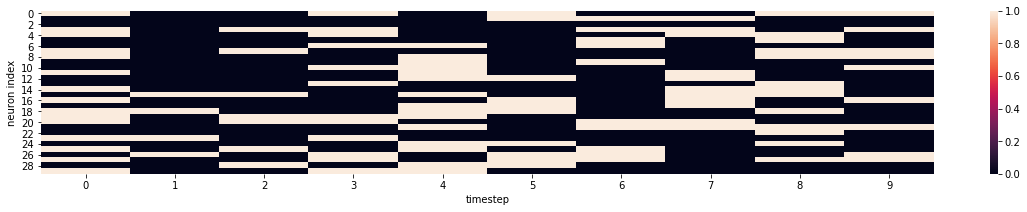

In [231]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes)
plt.xlabel("timestep")
plt.ylabel("neuron index")

In [232]:
def log_likelihood(curr_weights):

#     total_potential = np.matmul(curr_weights, phi) - eta_0 * eta[0, :]

#     rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
#     LL = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt

    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    rho = rho_0 * np.exp((total_potential - v) / delta_u)
    LL = np.sum(np.multiply(np.log(rho), spikes) - rho) * dt

    return -LL

In [233]:
# x0 = np.random.normal(loc=0, scale=0.1, size=num_neurons)
x0 = np.random.normal(loc=0, scale=0.1, size=[num_neurons, num_neurons])
res = optimize.minimize(log_likelihood, x0, options={'disp': True}, tol=1e-5)

         Current function value: 116.397332
         Iterations: 116
         Function evaluations: 129889
         Gradient evaluations: 144


In [244]:
## Take gradient of M network LL wrt M weights and update M weights
from autograd import grad
import autograd.numpy as np

x0 = np.random.normal(loc=0, scale=0.1, size=[num_neurons, num_neurons])
learned_weights = x0
grad_LL = grad(log_likelihood)

from autograd.misc.optimizers import adam
optimized_params = adam(grad_LL, x0, step_size=mu_M, num_iters=5000)


# for inum in range(5000):
#     curr_LL = log_likelihood(learned_weights)
#     M_weights_gradients = grad_LL(learned_weights)

#     learned_weights -= mu_M * M_weights_gradients
#     if inum % 500 == 0:
#         print curr_LL

TypeError: log_likelihood() takes exactly 1 argument (2 given)

In [235]:
print np.sum((np.reshape(res.x, [num_neurons, num_neurons]) - weights)**2)
print np.sum((learned_weights - weights)**2)

1388073.9183741584
16.144187794853273


In [219]:
# learned_weights = np.reshape(res.x, [num_neurons, num_neurons])
spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1


for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights, phi[:, tt]) - eta_0 * eta[:, tt]
    
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

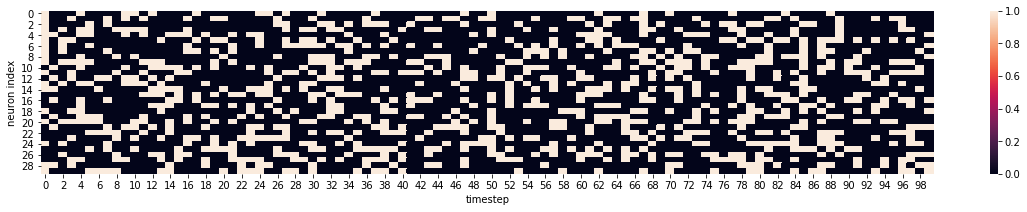

In [220]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :100])
plt.xlabel("timestep")
plt.ylabel("neuron index")

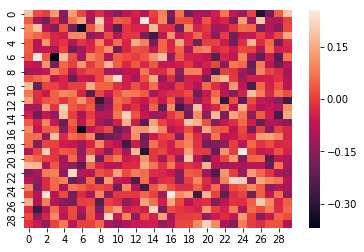

In [221]:
# sns.heatmap(np.reshape(res.x, [num_neurons, num_neurons]))
sns.heatmap(learned_weights)